**20MAI0005_Abhishek_Kumar**

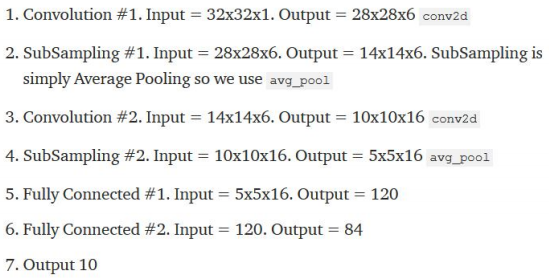

## Downloading Libraries


In [ ]:
#mnist data--> Four files are available on this site, http://yann.lecun.com/exdb/mnist/:

from requests import get

def download_file(url, file_name):
    with open(file_name, "wb") as file:
        response = get(url)
        file.write(response.content)

## Load the data

In [ ]:
download_file('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', 'train-images-idx3-ubyte.gz')
download_file('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', 'train-labels-idx1-ubyte.gz')
download_file('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', 't10k-images-idx3-ubyte.gz')
download_file('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', 't10k-labels-idx1-ubyte.gz')

In [ ]:
import gzip
import numpy as np
import pandas as pd
from time import time

from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import keras.layers as layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.callbacks import TensorBoard

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
def read_mnist(images_path: str, labels_path: str):
    with gzip.open(labels_path, 'rb') as labelsFile:
        labels = np.frombuffer(labelsFile.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path,'rb') as imagesFile:
        length = len(labels)
        # Load flat 28x28 px images (784 px), and convert them to 28x28 px
        features = np.frombuffer(imagesFile.read(), dtype=np.uint8, offset=16) \
                        .reshape(length, 784) \
                        .reshape(length, 28, 28, 1)
        
    return features, labels

In [ ]:
train = {}
test = {}

train['features'], train['labels'] = read_mnist('train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz')
test['features'], test['labels'] = read_mnist('t10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz')

## Explore the dataset

In [ ]:
print('Number of training images:', train['features'].shape[0])
print('Number of test images:', test['features'].shape[0])

Number of training images: 60000
Number of test images: 10000


### Displaying some images from dataset

In [ ]:
def display_image(position):
    image = train['features'][position].squeeze()
    plt.title('Example %d. Label: %d' % (position, train['labels'][position]))
    plt.imshow(image, cmap=plt.cm.gray_r)

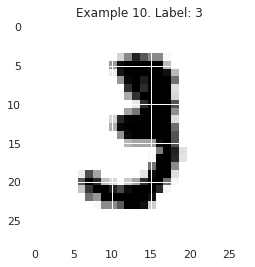

In [ ]:
display_image(10)

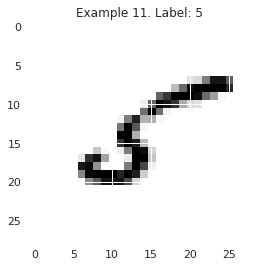

In [ ]:
display_image(11)

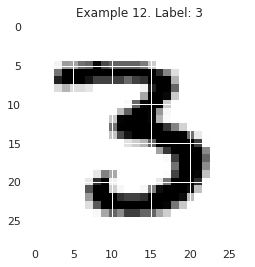

In [ ]:
display_image(12)

### Plotting training data --> labels and count of training data

In [ ]:
train_labels_count = np.unique(train['labels'], return_counts=True)
dataframe_train_labels = pd.DataFrame({'Label':train_labels_count[0], 'Count':train_labels_count[1]})
dataframe_train_labels

,Label,Count
0,0,5923
1,1,6742
2,2,5958
3,3,6131
4,4,5842
5,5,5421
6,6,5918
7,7,6265
8,8,5851
9,9,5949


### Splitting into training and validation set

In [ ]:
validation = {}
train['features'], validation['features'], train['labels'], validation['labels'] = train_test_split(train['features'], train['labels'], test_size=0.2, random_state=0)

In [ ]:
print('Number of training images:', train['features'].shape[0])
print('Number of validation images:', validation['features'].shape[0])

Number of training images: 48000
Number of validation images: 12000


In [ ]:
print("Image Shape: {}".format(train['features'][0].shape))

Image Shape: (28, 28, 1)


## Preparing input features:
The LeNet architecture accepts a 32x32 pixel images as input, mnist data is 28x28 pixels. We simply pad the images with zeros to overcome that.

In [ ]:
# Pad images with 0s
train['features']      = np.pad(train['features'], ((0,0),(2,2),(2,2),(0,0)), 'constant')
validation['features'] = np.pad(validation['features'], ((0,0),(2,2),(2,2),(0,0)), 'constant')
test['features']       = np.pad(test['features'], ((0,0),(2,2),(2,2),(0,0)), 'constant')
    
print("Updated Image Shape: {}".format(train['features'][0].shape))

Updated Image Shape: (32, 32, 1)


## Implementation:

In [ ]:
model = keras.Sequential()
model.add(layers.Conv2D(filters=6, kernel_size=(5,5), activation='relu', input_shape=(32, 32, 1)))
model.add(layers.MaxPool2D(strides=2))
model.add(layers.Conv2D(filters=16, kernel_size=(5,5), padding='valid', activation='relu'))
model.add(layers.MaxPool2D(strides=2))
model.add(layers.Flatten())
model.add(layers.Dense(120, activation='relu'))
model.add(layers.Dense(84, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [ ]:
model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               48120     
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

### Checking Accuracy of the model

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [ ]:
EPOCHS = 200
BATCH_SIZE = 150

In [ ]:
X_train, y_train = train['features'], to_categorical(train['labels'])
X_validation, y_validation = validation['features'], to_categorical(validation['labels'])

train_generator = ImageDataGenerator().flow(X_train, y_train, batch_size=BATCH_SIZE)
validation_generator = ImageDataGenerator().flow(X_validation, y_validation, batch_size=BATCH_SIZE)

In [ ]:
print('# of training images:', train['features'].shape[0])
print('# of validation images:', validation['features'].shape[0])

steps_per_epoch = X_train.shape[0]//BATCH_SIZE
validation_steps = X_validation.shape[0]//BATCH_SIZE

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_generator, validation_steps=validation_steps, 
                    shuffle=True, callbacks=[tensorboard])

# of training images: 48000
# of validation images: 12000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
320/320 [==============================] - 35s 9ms/step - loss: 4.2095 - accuracy: 0.6721 - val_loss: 0.1839 - val_accuracy: 0.9467
Epoch 2/200
320/320 [==============================] - 2s 6ms/step - loss: 0.1454 - accuracy: 0.9574 - val_loss: 0.1214 - val_accuracy: 0.9617
Epoch 3/200
320/320 [==============================] - 2s 6ms/step - loss: 0.0861 - accuracy: 0.9733 - val_loss: 0.0970 - val_accuracy: 0.9712
Epoch 4/200
320/320 [==============================] - 2s 6ms/step - loss: 0.0574 - accuracy: 0.9826 - val_loss: 0.0912 - val_accuracy: 0.9737
Epoch 5/200
320/320 [==============================] - 2s 6ms/step - loss: 0.0419 - accuracy: 0.9865 - val_loss: 0.0915 - val_accuracy: 0.9732
Epoch 6/200
320/320 [==============================] - 2s 6ms/step - loss: 0.0324 - accuracy: 0.9893 - val_loss: 0.0829 - val_accuracy: 0.9787
Epoch 7/200
320/320 [==============================] - 2s 6ms/step - loss: 0.0281 - accuracy: 0.9909 - val_loss: 0.0774 - val_accuracy: 0.978

In [ ]:
score = model.evaluate(test['features'], to_categorical(test['labels']))
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.2179 - accuracy: 0.9901
Test loss: 0.21790377795696259
Test accuracy: 0.9901000261306763
